# Micrograd: 간단한 Autograd Engine 구현하기
[MNC 박성호 매니저]


## 0. 개요/목표


*   Micrograd = 간소화된 Autograd engine (Automatic gradient engine)
*   Backpropagation 알고리즘과 MLP를 python으로 직접 구현하여 PyTorch나 TensorFlow같은 framework의 작동원리 이해하기



#### 참고자료:
* Backpropagation을 제대로 이해해야 하는 이유 ([링크](https://karpathy.medium.com/yes-you-should-understand-backprop-e2f06eab496b))
* Micrograd 라이브러리: https://github.com/karpathy/micrograd
* Andrej Karpathy 강의 영상: https://www.youtube.com/watch?v=VMj-3S1tku0
* Stanford CS231n Backpropagation 강의 ([링크](https://www.youtube.com/watch?v=d14TUNcbn1k&list=PLC1qU-LWwrF64f4QKQT-Vg5Wr4qEE1Zxk&index=4))

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

#### Util

In [38]:
# 그래프 그림 그리기 위한 함수

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot1(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


## 1. 미분

* 순간 변화량
* 기울기

참고 링크: https://en.wikipedia.org/wiki/Derivative




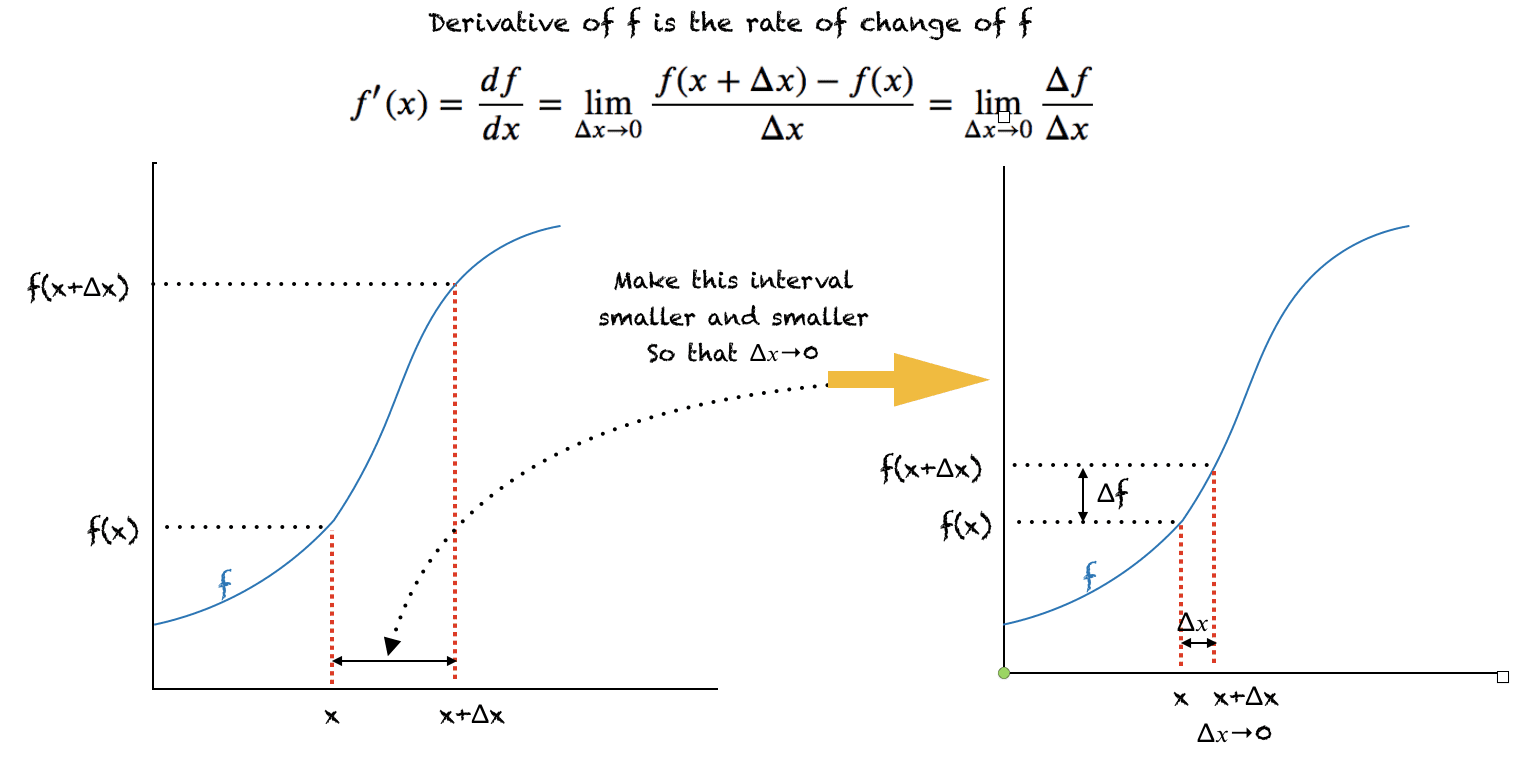

이미지 출처: https://machinelearningmastery.com/a-gentle-introduction-to-function-derivatives/

#### 예시 1.
$f(x) = 3x^2 - 4x + 5$

In [5]:
def f(x):
  return 3*x**2 - 4*x + 5

In [6]:
f(3.0)

20.0

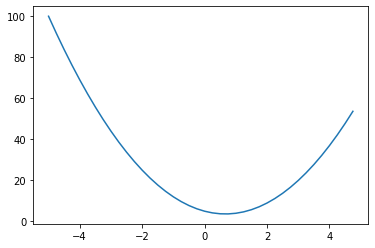

In [7]:
xs = np.arange(-5, 5, 0.25) 
ys = f(xs)
plt.plot(xs, ys)

**미분값 추정**

$f(x) = 3x^2 - 4x + 5$

$\frac{df(x)}{dx} = 6x - 4$

In [8]:
h = 0.000001
x = 3
(f(x+h)-f(x))/h

14.000003002223593

In [9]:
x = -3
(f(x+h)-f(x))/h

-21.999997002808414

In [10]:
x = 2/3
(f(x+h)-f(x))/h

2.999378523327323e-06

#### 예시 2.

$ d = ab + c$

In [11]:
a = 2.0
b = -3.0
c = 10.0
d = a*b+c

In [12]:
d

4.0

$ \frac{dd}{da} = b$

In [13]:
h = 0.0001

#input
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c # f(x)
a += h
d2 = a*b + c # f(x + h)

print('d1',d1)
print('d2',d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


$\frac{dd}{dc} = 1$

In [14]:
# 컴퓨터는 미분을 식으로 나타내지 않고, 미세한 변화를 주어 어떤 차이가 발생하는지 추정하여 미분값을 계산한다 
h = 0.0001

#input
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1',d1)
print('d2',d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


#### Chain Rule

$x \to y \to z$

$\frac{dz}{dx} = \frac{dz}{dy} \cdot \frac{dy}{dx}$

Intuition:
* 자동차가 자전거보다 4배 빠르게 이동하고, 자전거가 사람보다 2배 빠르게 이동하면, 자동차는 사람보다 $4 \times 2 = 8$배 빠르게 이동한다.

* $\frac{dy}{dx} = 2$ & $\frac{dz}{dy}=4 \implies \frac{dz}{dx} = 8$

#### Computational Graph를 활용한 미분 계산하기

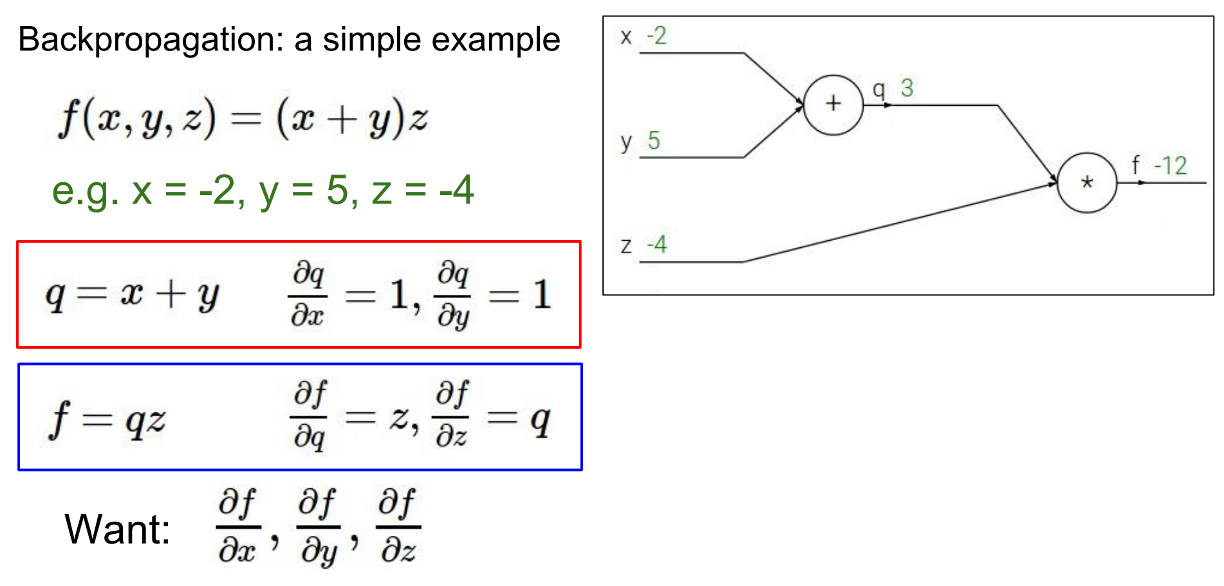

이미지 출처: Stanford CS231n

- computational graph의 오른쪽부터 back-propagation으로 gradient 계산  

$\frac{df}{df} = 1$

$\frac{df}{dz} = 3$

$\frac{df}{dq} = -4$

$\frac{df}{dx} = \frac{df}{dq} \cdot \frac{dq}{dx} = (-4)\times (1) = -4$

$\frac{df}{dy} = \frac{df}{dq} \cdot \frac{dq}{dy} = (-4)\times (1) = -4$

## 2. Value Object 구현 시작


In [15]:
class Value:
  def __init__(self, data):
    self.data = data

  def __repr__(self): # string representation
    return f"Value(data={self.data})"

In [16]:
a = Value(2.0)
a

Value(data=2.0)

#### Addition 추가

In [17]:
class Value:
  def __init__(self, data):
    self.data = data

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data)
    return out

In [18]:
a = Value(2.0)
b = Value(-3.0)
a + b

Value(data=-1.0)

In [19]:
# __add__ 는 +와 동일하다
a.__add__(b)

Value(data=-1.0)

#### Multiplication 추가

In [20]:
class Value:
  def __init__(self, data):
    self.data = data

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data)
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data)
    return out

In [21]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
a*b

Value(data=-6.0)

In [22]:
a.__mul__(b)

Value(data=-6.0)

In [23]:
a*b+c

Value(data=4.0)

#### children 기록
- a와 b를 더해 c라는 숫자가 만들어졌다면, c는 어떤 두 숫자를 연산해서 만들어졌는지 보관 

In [24]:
class Value:
  def __init__(self, data, _children=()):
    self.data = data
    self._prev = set(_children) # previous에 보관

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other)) # (self, other)이 _children 인자로 들어온다
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other))
    return out

In [25]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a*b+c
d

Value(data=4.0)

In [26]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

#### Operation 추가
- 어떤 연산이 사용되었는지를 보관

In [27]:
class Value:
  def __init__(self, data, _children=(), _op=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out

In [28]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a*b+c
d

Value(data=4.0)

In [29]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [30]:
d._op

'+'

#### label 추가

In [39]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out

In [40]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e+c; d.label='d' #d = a*b + c
d

Value(data=4.0)

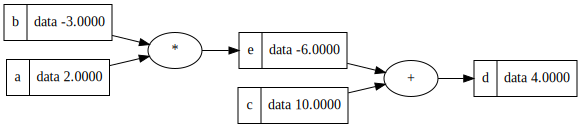

In [41]:
draw_dot1(d)

#### grad 추가
- d가 최종 loss라면, loss를 가중치(a,b,c,e)에 대해 미분한 값을 구해야 함
- 그 값을 보관하는 grad 추가

In [42]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out

In [43]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e+c; d.label='d' #d = a*b + c
f = Value(-2.0, label='f')
L = d * f; L.label='L'

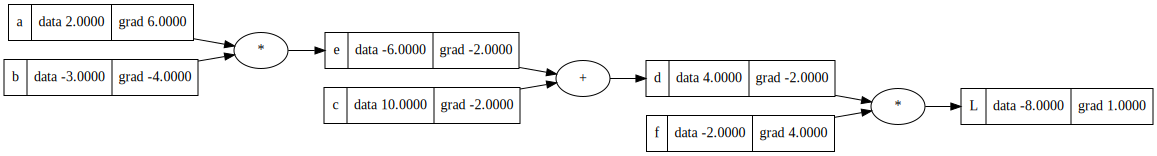

In [51]:
# 역전파를 할 때, 곱셈 노드가 있는 경우
# upstream gradient(L) = 1  -> d의 gradient = upstream gradient * f.data
# upstream gradient(e) = -2 -> a의 gradient = upstream gradient * b.data
# 덧셈 노드는, upstream gradient를 그대로 뿌려준다 
draw_dot(L)

## 3. Manual Backpropagation 예시 1

$ \frac{dL}{dL} = 1 $

In [45]:
L.grad = 1

$L = d \cdot f$

$\frac{dL}{dd} = f = -2$

$\frac{dL}{df} = d = 4$

In [46]:
d.grad = -2.0
f.grad = 4.0

$d = c + e \implies \frac{dd}{dc} = 1$ & $\frac{dd}{de} = 1$


$\frac{dL}{dc} = \frac{dL}{dd} \cdot \frac{dd}{dc} = (-2.0) \times (1.0)$

$\frac{dL}{de} = \frac{dL}{dd} \cdot \frac{dd}{de} = (-2.0) \times (1.0)$





In [47]:
c.grad = -2.0*1.0
e.grad = -2.0*1.0

$ e = a \times b \implies \frac{de}{da} = b$ & $\frac{de}{db} = a$

$\frac{dL}{da} = \frac{dL}{de} \cdot \frac{de}{da} = (-2.0) \times b = (-2.0) \times (-3.0)$

$\frac{dL}{db} = \frac{dL}{de} \cdot \frac{de}{db} = (-2.0) \times a = (-2.0) \times (2.0)$

In [48]:
a.grad = -2.0*-3.0
b.grad = -2.0*2.0

In [49]:
# d.grad = -2인지 확인
def lol():
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label='e'
  d = e+c; d.label='d' #d = a*b + c
  f = Value(-2.0, label='f')
  L = d * f; L.label='L'
  L1 = L.data

  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label='e'
  d = e+c; d.label='d' #d = a*b + c
  d.data += h
  f = Value(-2.0, label='f')
  L = d * f; L.label='L'
  L2 = L.data

  print((L2-L1)/h)

lol()

-2.000000000000668


In [50]:
# f.grad = 4인지 확인
def lol():
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label='e'
  d = e+c; d.label='d' #d = a*b + c
  f = Value(-2.0, label='f')
  L = d * f; L.label='L'
  L1 = L.data

  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label='e'
  d = e+c; d.label='d' #d = a*b + c
  f = Value(-2.0 + h, label='f')
  L = d * f; L.label='L'
  L2 = L.data

  print((L2-L1)/h)

lol()

3.9999999999995595


## 4. Manual Backpropagation 예시 2: Neuron

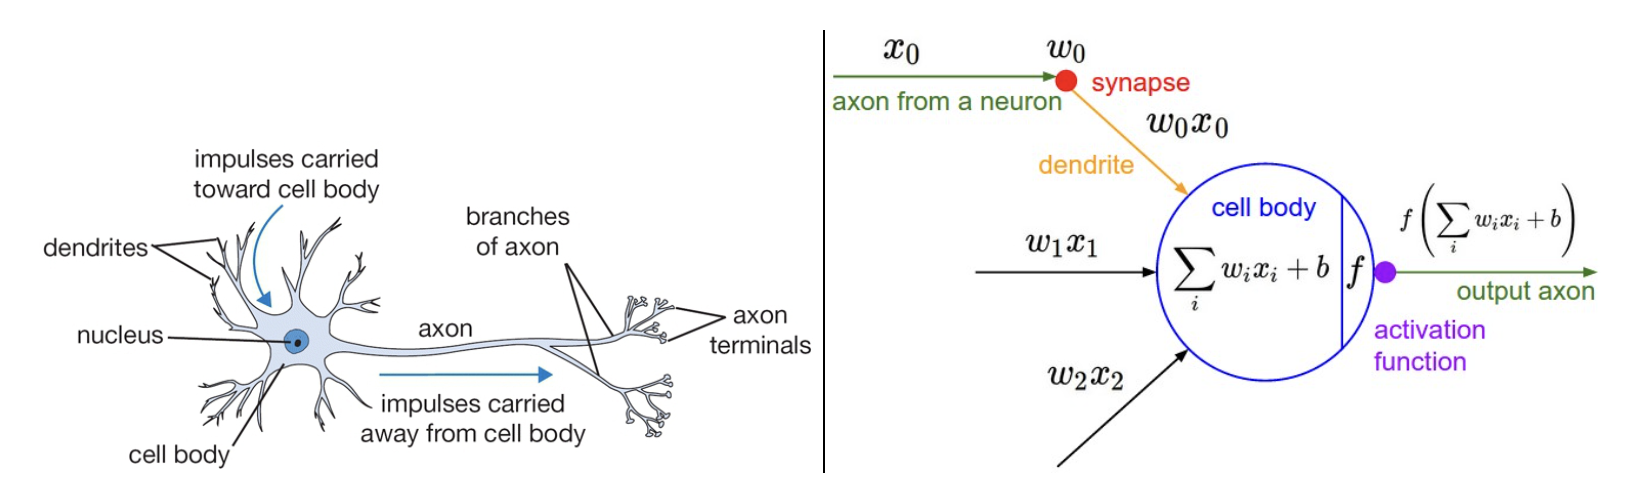

In [52]:
# 2차원 뉴런
# input data
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights
w1 = Value(-3.0,label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1+x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

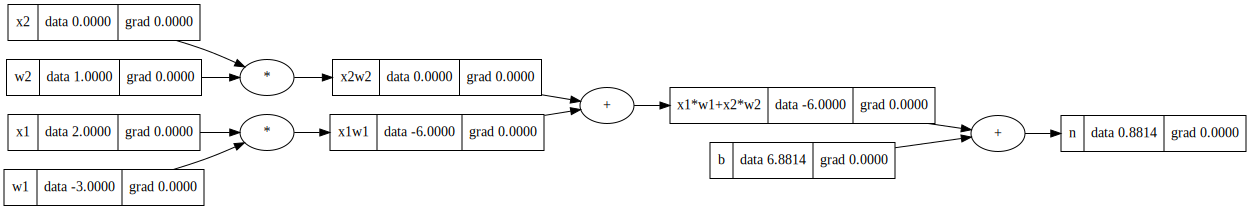

In [53]:
draw_dot(n)

#### tanh 추가하기
- back propagation하기 전에 non-linearity 추가

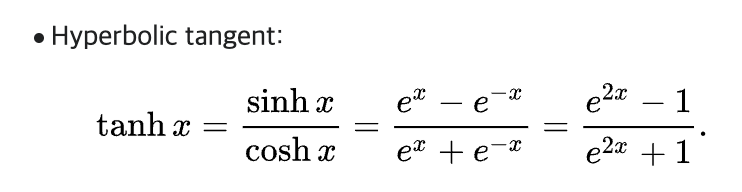

이미지 출처: https://en.wikipedia.org/wiki/Hyperbolic_functions

In [54]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out

  def tanh(self):
    n = self.data
    t = (math.exp(2*n) - 1)/(math.exp(2*n)+1)
    out = Value(t, (self,), 'tanh')  # 본인만 인자로 받기 때문에 children이 (self,) 하나뿐이다 / label은 'tanh'
    return out

In [55]:
# input data
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights
w1 = Value(-3.0,label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1+x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label='o'

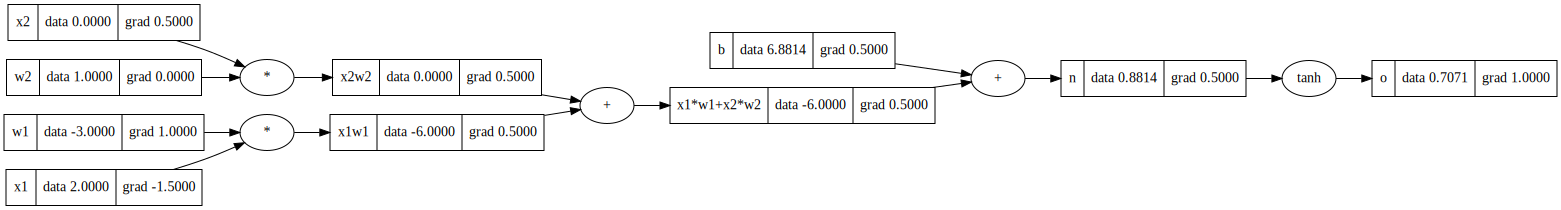

In [63]:
# tanh를 통과하면서 최종 output 값이 달라진다
draw_dot(o)

In [57]:
o.grad = 1.0

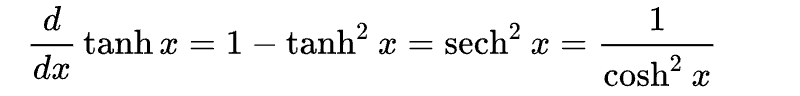

이미지 출처: https://en.wikipedia.org/wiki/Hyperbolic_functions

In [58]:
#o = tanh(n)
#do/dn = 1 - tanh(n)**2 = 1 - o**2
1 - (0.7071)**2

0.5000095900000001

In [59]:
n.grad = 0.5

'+'는 upstream gradient를 그대로 전파

In [60]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [61]:
x1w1.grad = 0.5
x2w2.grad = 0.5

'*'는 upstream gradient를 뒤집고 곱해서 전파

In [62]:
x1.grad = 0.5*w1.data
w1.grad = 0.5*x1.data

x2.grad = 0.5*w2.data
w2.grad = 0.5*x2.data

## 5. Automatic gradient 추가하기

In [64]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
    self._backward = lambda: None  # lambda: 함수를 정의한다

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():  # add 함수 내의 backward 정의: upstream gradient에 1을 곱해서 그대로 전파
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad
    out._backward = _backward
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    def _backward(): # multiply 함수 내의 backward 정의: upstream gradient * 반대편 데이터
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad
    out._backward = _backward
    return out

  def tanh(self):
    n = self.data
    t = (math.exp(2*n) - 1)/(math.exp(2*n)+1)
    out = Value(t, (self,), 'tanh')
    def _backward(): # tanh 함수 내의 backward 정의: (1 - output**2)에 chain rule에 의해 upstream gradient를 곱한다
      self.grad = (1 - t**2) * out.grad
    out._backward = _backward
    return out

In [65]:
# 2차원 뉴런
# input data
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights
w1 = Value(-3.0,label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1+x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label='o'

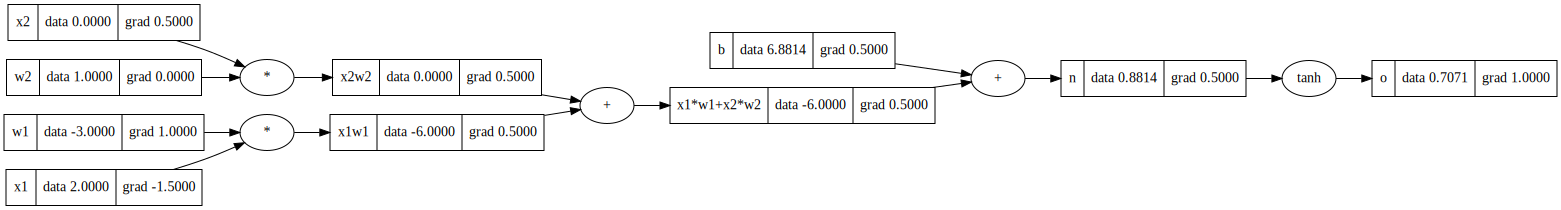

In [72]:
draw_dot(o)

In [67]:
o.grad = 1.0

In [68]:
o._backward()

In [69]:
n._backward()

In [70]:
x1w1x2w2._backward()

In [71]:
x1w1._backward()
x2w2._backward()

### 순서대로 backward 부르기

Topological sort: 화살표들이 아래 이미지처럼 한 방향으로만 가도록 sorting  
※ forward는 왼쪽에서 오른쪽, backward는 오른쪽에서 왼쪽으로 이동  

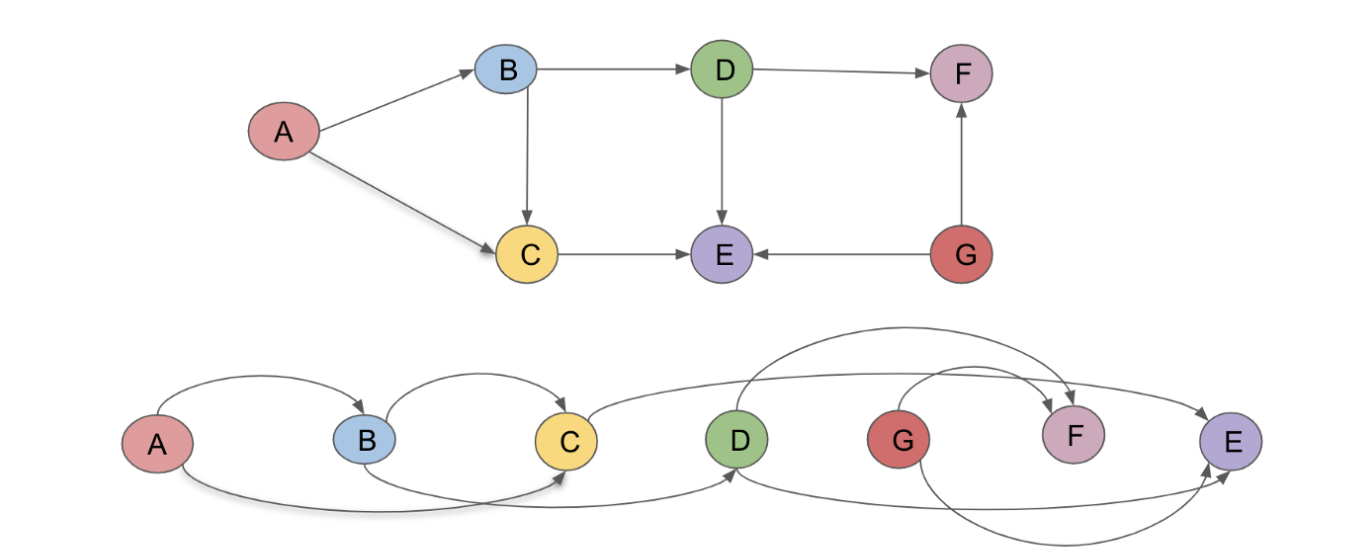

이미지 출처: https://medium.com/@konduruharish/topological-sort-in-typescript-and-c-6d5ecc4bad95

In [75]:
# topological sort를 통해 노드(Value)를 순서대로 출력
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)

build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

### Backward 한번에 실행

In [76]:
# input data
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights
w1 = Value(-3.0,label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1+x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label='o'

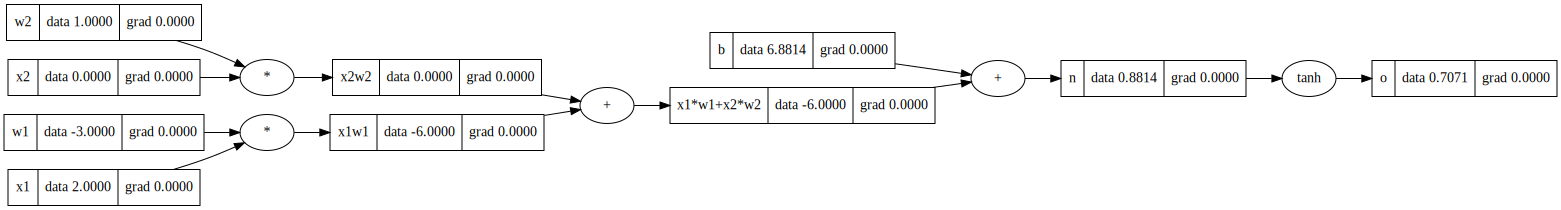

In [77]:
draw_dot(o)

In [78]:
o.grad = 1.0

In [79]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)

In [81]:
topo

[Value(data=6.881373587019543),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [82]:
for node in reversed(topo):
  node._backward()

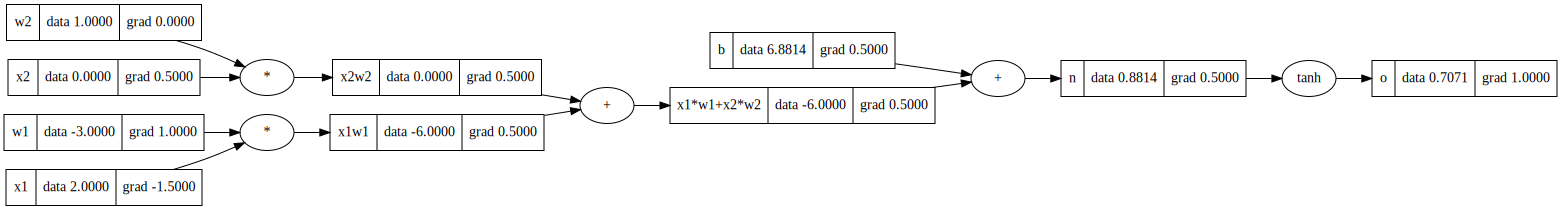

In [83]:
draw_dot(o)

In [84]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
    self._backward = lambda: None

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad
    out._backward = _backward
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad
    out._backward = _backward
    return out

  def tanh(self):
    n = self.data
    t = (math.exp(2*n) - 1)/(math.exp(2*n)+1)
    out = Value(t, (self,), 'tanh')
    def _backward():
      self.grad = (1 - t**2) * out.grad
    out._backward = _backward
    return out

  def backward(self): # backward 함수 정의
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [85]:
# input data
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights
w1 = Value(-3.0,label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1+x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label='o'

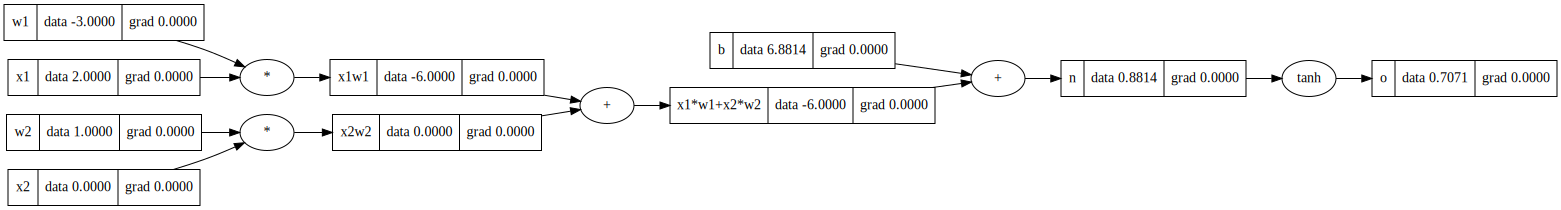

In [86]:
draw_dot(o)

In [87]:
o.backward()

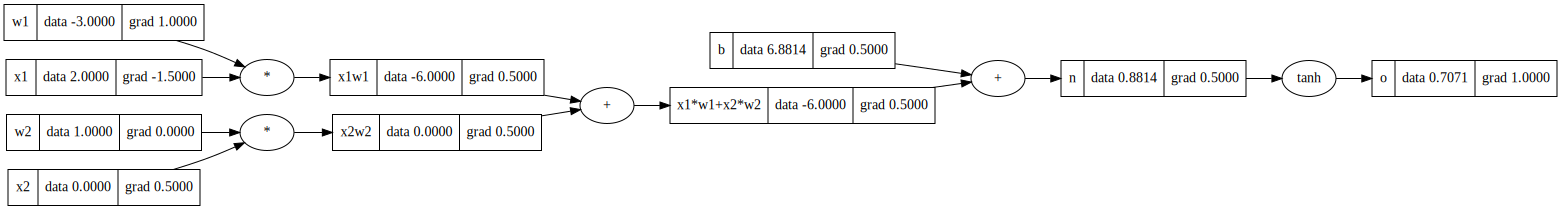

In [88]:
draw_dot(o)

## 6. 버그: 같은 값이 2번 이용될 때
- 하나의 노드를 두 번 이상 사용하면, backward를 호출할 때 해당 gradient 값이 override 된다.

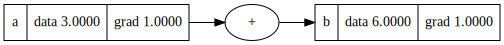

In [89]:
# b = 2a
# db/da = 2인데 1이 출력됨
a = Value(3.0, label='a')
b = a+a; b.label = 'b'
b.backward()
draw_dot(b)

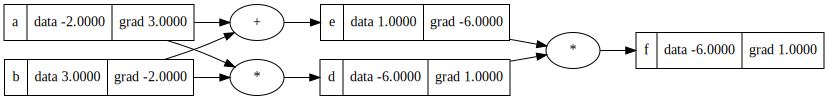

In [90]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a*b; d.label = 'd'
e = a+b; e.label='e'
f = d*e; f.label='f'

f.backward()

draw_dot(f)

#### Multivariable Chain Rule

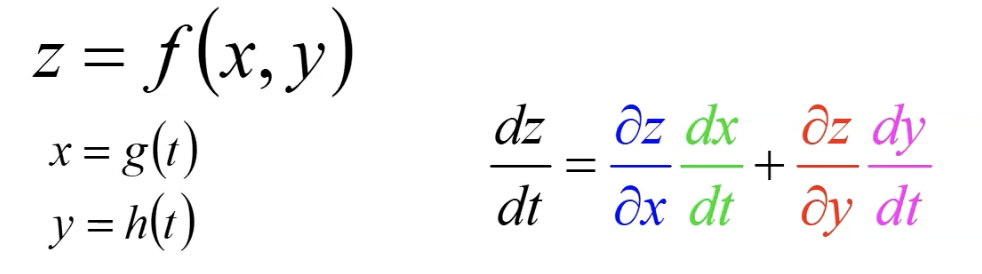

이미지 출처: https://www.youtube.com/watch?v=68yMnQ0Qe3Q

t가 변화하면 z가 변하는데, x를 통해서도 y를 통해서도 변하게 된다  
t에 의한 총 변화량을 알고 싶다면? x를 통한 변화량 + y를 통한 변화량

In [91]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
    self._backward = lambda: None

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def tanh(self):
    n = self.data
    t = (math.exp(2*n) - 1)/(math.exp(2*n)+1)
    out = Value(t, (self,), 'tanh')
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

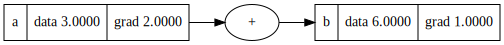

In [92]:
a = Value(3.0, label='a')
b = a+a; b.label = 'b'
b.backward()
draw_dot(b)

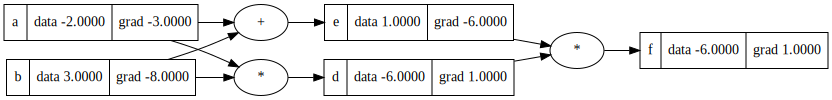

In [93]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a*b; d.label = 'd'
e = a+b; e.label='e'
f = d*e; f.label='f'

f.backward()

draw_dot(f)

## 7. 추가로 필요한 기능 구현하기

In [94]:
# a는 Value, 1은 int
a = Value(2.0, label='a')
a + 1

AttributeError: 'int' object has no attribute 'data'

In [95]:
a * 2

AttributeError: 'int' object has no attribute 'data'

In [96]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
    self._backward = lambda: None

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other) # other가 Value이면 그대로 두고, Value가 아니면 변환
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def tanh(self):
    n = self.data
    t = (math.exp(2*n) - 1)/(math.exp(2*n)+1)
    out = Value(t, (self,), 'tanh')
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [97]:
a = Value(2.0)
a + 1

Value(data=3.0)

In [98]:
a * 2

Value(data=4.0)

In [99]:
1 + a

TypeError: unsupported operand type(s) for +: 'int' and 'Value'

In [100]:
2 * a
# a*2 ==== a.__mul__(2)

TypeError: unsupported operand type(s) for *: 'int' and 'Value'

In [101]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
    self._backward = lambda: None

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __radd__(self, other): # reverse add: 처음에 __add__를 하고, 오류가 발생하면 순서를 바꿔서 더해봐라
    return self+other

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other): # reverse multiply
    return self*other

  def tanh(self):
    n = self.data
    t = (math.exp(2*n) - 1)/(math.exp(2*n)+1)
    out = Value(t, (self,), 'tanh')
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [102]:
a = Value(2.0)
1 + a

Value(data=3.0)

In [103]:
2 * a

Value(data=4.0)

#### tanh 다시 구현하기

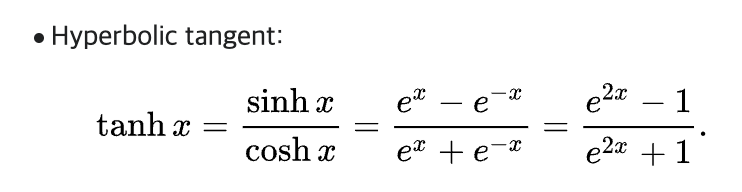

추가적으로 필요한 기능:
* subtraction
* exponentiation
* division

Derivative Rules:
* $\frac{d}{dx}x^n = nx^{n-1}$
* $\frac{d}{dx}e^x = e^x$

In [104]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
    self._backward = lambda: None

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out
  
  def __radd__(self, other):
    return self+other

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other):
    return self*other

  def tanh(self):
    n = self.data
    t = (math.exp(2*n) - 1)/(math.exp(2*n)+1)
    out = Value(t, (self,), 'tanh')
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out

  def exp(self):   # 2. exponential 구현
    x = self.data
    out = Value(math.exp(x), (self,), 'exp') # input이 self 뿐이므로 children은 (self,) / operation은 exp로 정의
    def _backward():          
      self.grad += out.data * out.grad   # exponential의 backward: e^x * upstream gradient
    out._backward = _backward
    return out

  def __truediv__(self, other):  # 4. 나눗셈 구현: a/b = a * (1/b) = a * (b ** -1)
    return self * other**-1

  def __pow__(self, other):  # 3. python이 지수화를 이해하려면 power 함수 필요
    assert isinstance(other, (int, float)), "int나 float만 가능"
    out = Value(self.data**other, (self,), f'**{other}')  # children, label
    def _backward():
      self.grad += other* self.data**(other - 1) * out.grad  # n*x^(n-1) * upstream gradient 
    out._backward = _backward
    return out

  def __neg__(self):        # 1. python이 -를 이해하려면 neg 함수 필요
    return self * -1

  def __sub__(self, other): # 2. 뺄셈 구현
    return self + (-other)

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

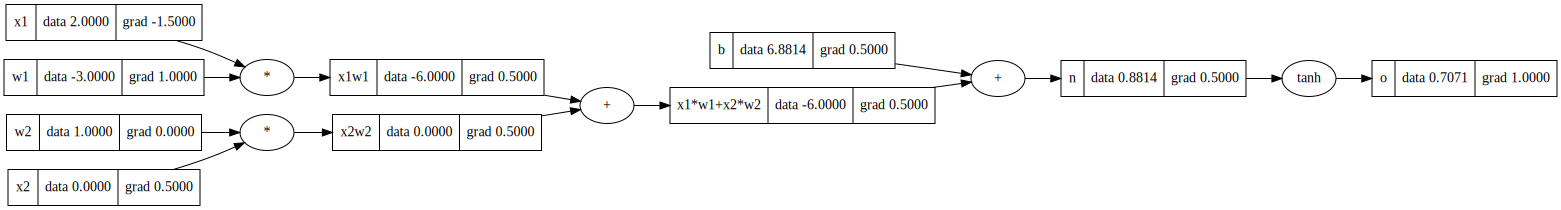

In [105]:
# input data
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights
w1 = Value(-3.0,label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1+x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label='o' # tanh 함수

o.backward()
draw_dot(o)


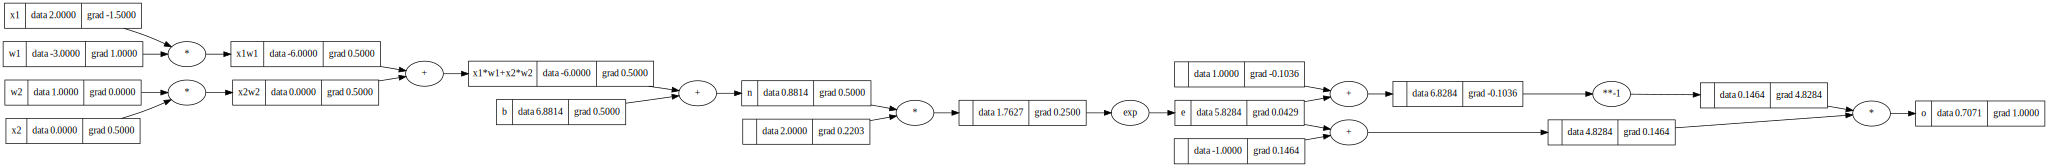

In [106]:
# input data
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights
w1 = Value(-3.0,label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1+x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# tanh 함수 대신 수식으로 직접 구현
e = (2*n).exp(); e.label ='e'
o = (e-1)/(e+1); o.label = 'o'

o.backward()
draw_dot(o)


복잡한 함수나 간단한 함수나 다 forward와 backward만 정의할 수 있으면 된다!

## 8. PyTorch 와 비교

In [107]:
import torch

In [108]:
# python은 기본적으로 float64 data type을 이용하는데, pytorch는 기본적으로 float32를 사용
# double을 하면 float64로 변환됨

# required_grad = True로 해야 역전파할 때 gradient가 계산됨
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())
# 우리가 지금까지 구현한 것이 pytorch와 동일하다

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


## 9. 뉴럴 네트워크 구현

### 뉴런

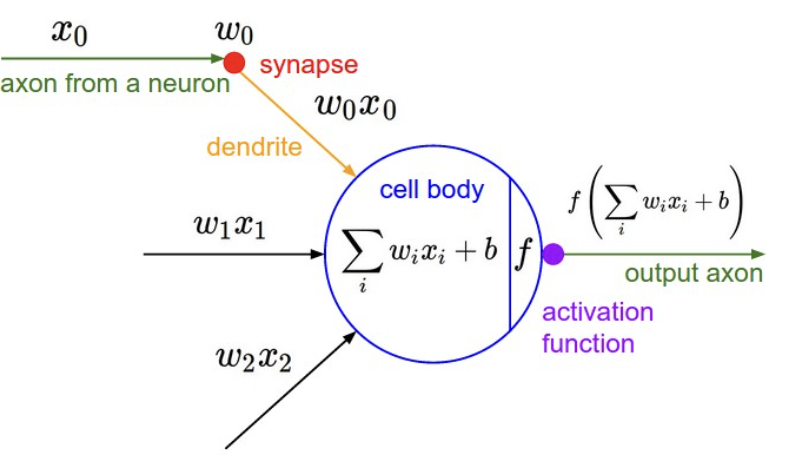

In [111]:
class Neuron:
  
  def __init__(self, nin): #nin = number of inputs
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # input 개수만큼 가중치 Value를 random하게 만들어서(단, -1~1 사이의 값을 갖는다) list에 저장
    self.b = Value(random.uniform(-1,1)) # bias 역시 -1~1사이의 값으로 random하게 지정
    
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # w는 list of weights, x는 list of inputs
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

In [112]:
# 데이터를 뉴런에 넣어주면 결과가 나온다
x = [2.0, 3.0]
n = Neuron(2)
n(x) # call 함수가 호출된다

Value(data=0.9996450717001585)

### Layer
- 여러 개의 뉴런

In [109]:
class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)] # 아래 이미지: input이 3개인 뉴런을 4개 만들어라
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    #return [p for neuron in self.neurons for p in neuron.parameters()]
    params = []
    for neuron in self.neurons:
      ps = neuron.parameters()
      params.extend(ps)
    return params


In [113]:
# 뉴런이 3개이므로 output이 3개 출력된다
x = [2.0, 3.0]
n = Layer(2,3)
n(x)

[Value(data=-0.10653273732705379),
 Value(data=-0.7989160688737663),
 Value(data=0.9929846143458303)]

### MLP
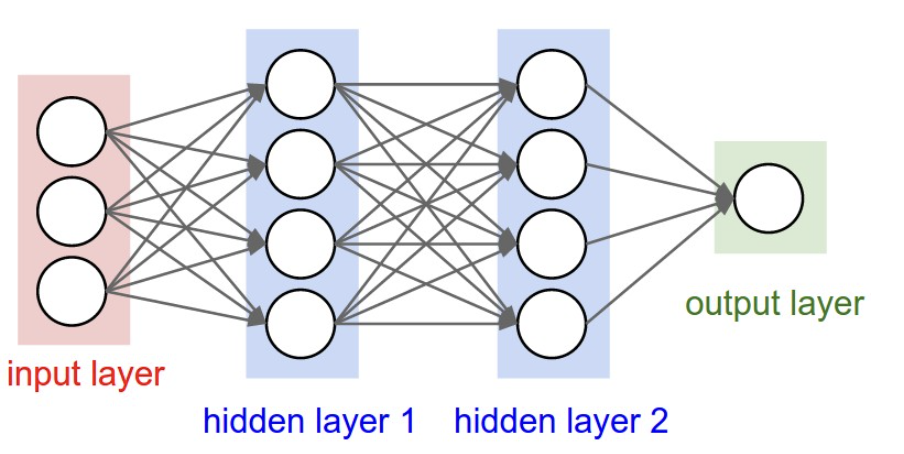

이미지 출처: Stanford cs231n

In [114]:
# NLP: 여러 개의 layers를 list에 넣은 것
class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))] # input이 nin & output의 크기가 nouts(list)의 첫번째인 layer를 만듦
                                                                     # nouts의 첫번째가 input의 개수 & nouts의 두번째가 output인 layer를 만듦
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    #return [p for layer in self.layers for p in layer.parameters()]
    params = []
    for layer in self.layers:
      ps = layer.parameters()
      params.extend(ps)
    return params

In [115]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.17451959346578516)

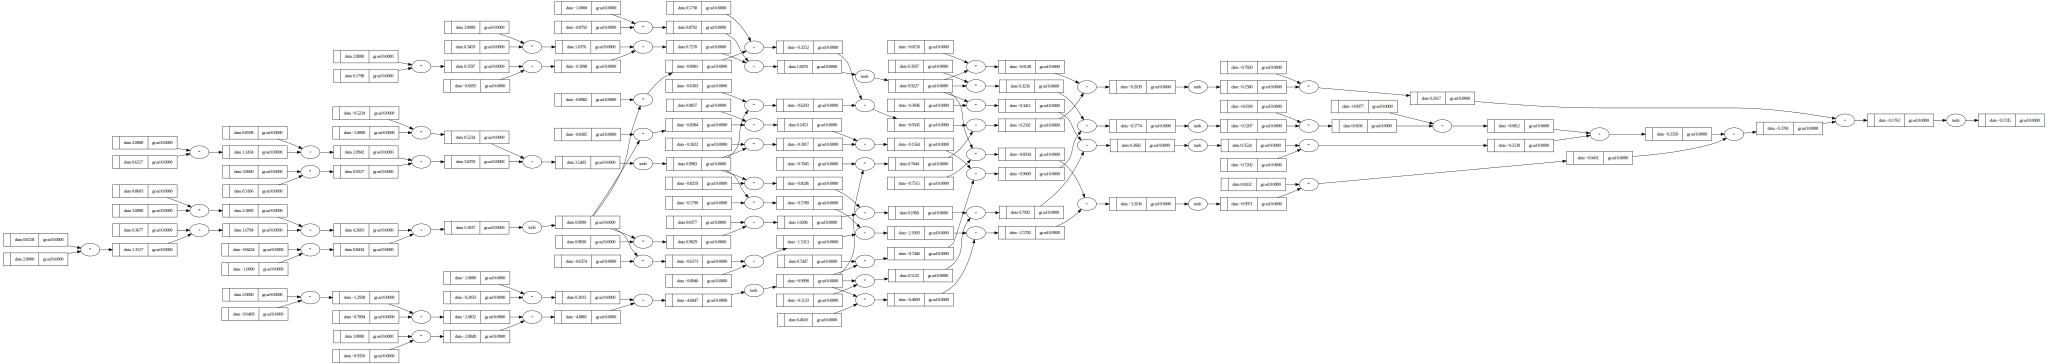

In [116]:
draw_dot(n(x))

## 10. 간단한 뉴럴 네트워크 학습

In [117]:
model = MLP(3, [4,4,1])

In [118]:
xs = [ #inputs: 3차원 데이터가 4개
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # targets: inputs에 대응하는 targets

In [119]:
ypred = [model(x) for x in xs]
ypred
# targets과 거리가 먼 값이 도출됨

[Value(data=-0.7696037918637973),
 Value(data=0.6084430725953873),
 Value(data=-0.8505849965851792),
 Value(data=-0.8888216501943614)]

In [120]:
# NN의 성능을 높이기 위해 loss(예측값과 targets의 차이)를 최소화
# MSE
[(yout - ytrue)**2 for ytrue,yout in zip(ys, ypred)]

# 3번째 벡터를 제외하곤 모두 loss 값이 크다

[Value(data=3.1314975801787295),
 Value(data=2.5870891177800903),
 Value(data=0.02232484324545092),
 Value(data=3.567647226242951)]

In [121]:
loss = sum((yout - ytrue)**2 for ytrue,yout in zip(ys, ypred))
loss

Value(data=9.308558767447222)

In [122]:
# loss를 모든 weights에 대해서 미분하고 gradient 구한 뒤 역전파해야 함
model.layers[0].neurons[0].w[0]

Value(data=-0.4785095070398635)

In [123]:
# 아직 back propagation하기 전이므로 gradient = 0
model.layers[0].neurons[0].w[0].grad

0.0

In [124]:
# 모든 weights와 변수들에 대해서 loss의 미분값(gradient)을 계산
loss.backward()

In [125]:
model.layers[0].neurons[0].w[0]

Value(data=-0.4785095070398635)

In [126]:
model.layers[0].neurons[0].w[0].grad

-0.1657868191476384

In [ ]:
draw_dot(loss)

In [127]:
model.parameters()

[Value(data=-0.4785095070398635),
 Value(data=0.9218049878564905),
 Value(data=-0.21262441620636152),
 Value(data=0.3256295072128079),
 Value(data=-0.20152414896352733),
 Value(data=0.8429499289081566),
 Value(data=-0.061662077847503216),
 Value(data=-0.7988064743021461),
 Value(data=-0.23719065356968083),
 Value(data=-0.6394122255369357),
 Value(data=0.012219037085390738),
 Value(data=-0.31505433520812165),
 Value(data=0.944417564248293),
 Value(data=-0.295705384404249),
 Value(data=0.3808564260874985),
 Value(data=-0.7873113372380169),
 Value(data=-0.9715943294069309),
 Value(data=0.3122628797834375),
 Value(data=-0.6216990431895446),
 Value(data=-0.7075024467319424),
 Value(data=-0.6807913967630024),
 Value(data=0.5824731119477156),
 Value(data=0.9505526847825847),
 Value(data=-0.8419033739986326),
 Value(data=0.6455624151311956),
 Value(data=0.35699757977337443),
 Value(data=-0.3222437402805247),
 Value(data=0.8905959871462297),
 Value(data=0.9289031043332772),
 Value(data=0.898651

In [128]:
len(model.parameters())

41

In [129]:
# gradients를 활용해 weights update
# lr = -0.01
for p in model.parameters():
  p.data += -0.01 * p.grad

In [130]:
model.layers[0].neurons[0].w[0]

Value(data=-0.4768516388483871)

In [131]:
# 1epoch 학습으로 loss가 줄어듦
ypred = [model(x) for x in xs]
loss = sum((yout - ytrue)**2 for ytrue,yout in zip(ys, ypred))
loss

Value(data=7.356235356123385)

### 제대로 학습

In [132]:
# 40 epoch 학습: loss가 0.03까지 줄어듦
for k in range(40):
  
  # forward pass
  ypred = [model(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in model.parameters():
    p.grad = 0.0 # 새로 iteration할 때 gradients 값을 초기화
  loss.backward()
  
  # update: optimizer.step()
  for p in model.parameters():
    p.data += -0.05 * p.grad
  
  print(k, loss.data)

0 7.356235356123385
1 2.7777156790222977
2 1.6898847130346049
3 1.152999503259279
4 0.6420166535900278
5 0.3624855240979953
6 0.2790525155003518
7 0.23306071599507183
8 0.19928000269363977
9 0.17345359832075738
10 0.15313445401623282
11 0.1367739075252815
12 0.12334589313048999
13 0.11214573701150063
14 0.10267469113364414
15 0.09457054888675881
16 0.08756434185324546
17 0.08145241924713945
18 0.07607792644894734
19 0.07131820694783109
20 0.06707604073648779
21 0.06327342871213748
22 0.05984710394569502
23 0.056745237458122495
24 0.05392498508036905
25 0.05135063619294575
26 0.04899219957434403
27 0.04682431101817536
28 0.04482538077883809
29 0.04297692183583488
30 0.04126301594238702
31 0.03966988570649198
32 0.038185549021871414
33 0.03679953800563335
34 0.03550266887168678
35 0.03428685232677549
36 0.033144936432614416
37 0.03207057565222548
38 0.031058121146278875
39 0.03010252841695957


In [133]:
ypred

[Value(data=0.9350171219698752),
 Value(data=-0.933559049200625),
 Value(data=-0.8957111357024358),
 Value(data=0.8970962254322964)]

In [134]:
ys

[1.0, -1.0, -1.0, 1.0]

back propagation과 multi layer perceptron 학습을 4개의 라이브러리를 활용해 구현